<a href="https://colab.research.google.com/github/FVaisfeld/NYT_NLP_analysis/blob/main/NYT_NLP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York Times headline regression analysis with LLM 

The Archive API returns an array of New York Times (NYT) articles for a specific month, spanning all the way back to 1851. I aim to evaluate the potential of a large language model for regression tasks, specifically predicting the publication date solely based on the article headlines. The resulting model could be utilized for exploratory analysis, examining the evolution of language over time. For instance, it could be employed to investigate how historical events influence language patterns.

In [ ]:
# let's get the data from the NYT api
import time 
yourkey = 'RAqO2c4Hdk6iFp0RoanDHPGzXppednzR'
months = range(1,2) # month range
years = range(1,101) #year range
first_year = 1922
for month in months:
  for y in years:
    
    year = first_year+y 
    date = f'{year}/{month*6}'
    url = f'https://api.nytimes.com/svc/archive/v1/{date}.json?api-key={yourkey}'
    !wget -O '{year}{month}.json' {url}
    time.sleep(10) # add some sleep for not running into api rate limits 


In [2]:
# open the json files and extract the date and headers into a list 
import json
headline = []
pub_date = []
for month in months:
  for y in years:  #range of the years 
    year = 1922+y
    try:
      with open(f'{year}{month}.json') as f:
          d = json.load(f)
          n_articles = len(d['response']['docs'])
          [ headline.append(d['response']['docs'][i]['headline']['main']) for i in range(n_articles) if len(d['response']['docs'][i]['headline']['main'])>0]
          [ pub_date.append(d['response']['docs'][i]['pub_date']) for i in range(n_articles) if len(d['response']['docs'][i]['headline']['main'])>0]
    except:
      continue



In [3]:
# example of headline 
print(headline[10])
print(len(headline))

SWISS LOSE AT TENNIS.; Czechoslovakia Wins Doubles Match in Davis Cup Play.
880722


In [ ]:
# get some libraries for plotting 
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')


In [5]:
# remove time from date since we only care about the day 
# fomat looks like this: '2004-01-16T14:18:00+0000'
for i,d in enumerate(pub_date):
  pub_date[i] = d[:d.find('T')]

pub_date[0]

'1923-06-01'

In [6]:
# concatenate headlines for same dates
import datetime

#let's sort the dates 
sorted_date = sorted(pub_date, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

#get difference dates
dates = sorted(set(sorted_date), key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

# concatenate same dates
art2date = []
for d in dates:
  day_ind = [i for i, x in enumerate(sorted_date) if x == d]
  st = {"date": d, "indices": day_ind}
  art2date.append(st)  

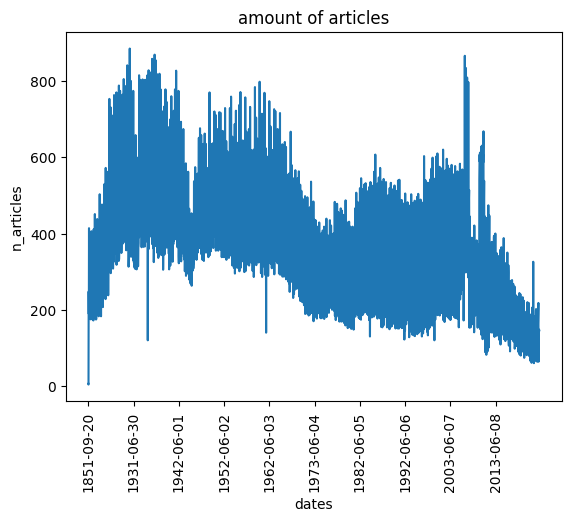

In [7]:
# plot how many articles we have per date 
import matplotlib.pyplot as plt
n_articles = [len(a['indices']) for a in art2date]
x = np.arange(len(n_articles))
fig, ax = plt.subplots()
plt.plot(x, n_articles)
plt.xticks(x, dates, rotation=90)  # Set text labels and properties.
ax.locator_params(nbins=10, axis='x')
plt.title('amount of articles')
plt.xlabel('dates') 
plt.ylabel('n_articles')
plt.show()

In [8]:
# check min number of articles per date
print(f'minimum number of articles per date: {np.min(n_articles)}')
print(f'average number of articles per date: {np.mean(n_articles)}')


minimum number of articles per date: 4
average number of articles per date: 325.9518874907476


In [9]:
# merge articles per date 
headDate = []
for i,a in enumerate(art2date):
  headDate.append([headline[i] for i in a['indices'] if len(headline[i])>0])

In [10]:
headDate[0]

['FOR THE HONDURAN BARBER; American Finds the New York Product Savage in Comparison.',
 "WHITMAN'S FAME GROWING.; Out of 200 Writers Only Three Re- port Poet's Influence Waning.",
 'STRENGTH OF WHISKY NEED NOT BE PROVED; Conviction of Seven Men Up- held, Although Alcoholic Con- tent Was Not Shown.',
 'FOREST FIRES SUBSIDING.; Up-State, Michigan and Canadian Blazes Checked by Hard Fighting.',
 "HAYWARD LEADS 'DRYS'; Federal Attorney Tells Governor He Must Keep His Oath. THOMAS CHIEF WET SPEAKER Playwright Declares Minority Has Right to Resist Law Invading Rights. SMITH SILENT AT THE END But Drys' Showing in Crowded Meeting Leaves Repeal Advocates Shaky. Assembly Chamber Crowded as Governor Hears Wet and Dry Pleas G0V. SMITH HEARS WET AND DRY APPEAL",
 'POCAHONTAS SEARCH ANGERS ENGLISHMEN; Loud Protests Are Voiced Over Disturbing 50 Bodies in an Old Churchyard. WANT PROCEEDINGS HALTED Exhumed Bodies Are Reburled With Prayers, but Some Skulls Are Held for Examination.']

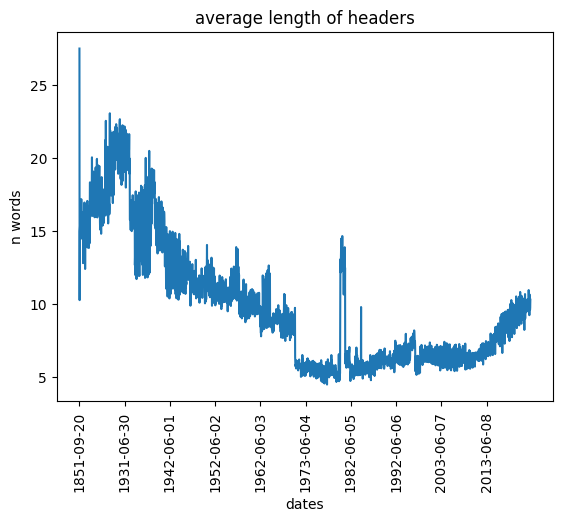

In [11]:
# check how long the concatenated headers per day in average are
# tokenization of the sentences
from nltk.tokenize import word_tokenize  
l_words = [len(word_tokenize(''.join(headers))) for headers in headDate]
x = np.arange(len(l_words))
fig, ax = plt.subplots()

plt.plot(x, np.array(l_words)/np.array(n_articles))
plt.xticks(x, dates,
       rotation=90)  # Set text labels and properties.

ax.locator_params(nbins=10, axis='x')
plt.title('average length of headers')
plt.xlabel('dates') 
plt.ylabel('n words')
plt.show()


Since the 1930s, the length of headers has generally decreased with a few exceptions until around 2013. However, since then, there appears to have been a continuous increase in header length.

In [12]:
# for creating a word cloud remove of the irrelevant stopwords and punctuation 
import string
string.punctuation
j_headline = ' '.join(headline)
tokens = word_tokenize(j_headline)
tokens = [char for char in tokens if char not in string.punctuation]
from nltk.corpus import stopwords
# remove stopwords
stop = stopwords.words('english')
tokens = [token for token in tokens if token not in stop]
# remove words less than three letters
tokens = [word for word in tokens if len(word) >= 3]
# remove article and title from tokens
tokens = [word for word in tokens if word not in ['Article', 'Title']]


In [13]:
print(tokens[:10])

['FOR', 'THE', 'HONDURAN', 'BARBER', 'American', 'Finds', 'New', 'York', 'Product', 'Savage']


In [ ]:
# creation of a word cloud of all headers over all years
!pip install WordCloud
from wordcloud import WordCloud
from PIL import Image
plt.figure(figsize=(20,20))
wc = WordCloud(max_font_size=50, max_words=100, background_color='white')
wordcloud_jan = wc.generate_from_text(' '.join(tokens))
plt.imshow(wordcloud_jan, interpolation='bilinear')
plt.title('word cloud of the most used words in headers')
plt.axis('off')
plt.show()

In [ ]:
# Usage of an embedding to make the sentences interpretable for a transfomrer model
!pip install transformers
from transformers import BertTokenizer as Tokenizer
tokenizer = Tokenizer.from_pretrained("bert-base-uncased")

maximum_length = 300 #here define number of input tokens
all_encoded_corpus = []

# iterate and tokenize
for i,h in enumerate(headDate):
  encoded_corpus = tokenizer(text=h,
                              add_special_tokens=True,
                              padding='max_length',
                              truncation='longest_first',
                              max_length=maximum_length,
                              return_attention_mask=True)

  all_encoded_corpus.append(encoded_corpus)
  

In [16]:
# the Bert model uses at the beginning the CLS token, between sentences the SEP token and at the end the PAD tokens
spezial_token = ['[CLS]', '[SEP]', '[PAD]']
CLS = tokenizer(spezial_token[0],add_special_tokens=False)['input_ids']
SEP = tokenizer(spezial_token[1],add_special_tokens=False)['input_ids']
PAD = tokenizer(spezial_token[2],add_special_tokens=False)['input_ids']
print(f'[CLS] token: {CLS}')
print(f'[SEP] token: {SEP}')
print(f'[PAD] token: {PAD}')

[CLS] token: [101]
[SEP] token: [102]
[PAD] token: [0]


In [17]:
# Concatenate multiple headers of the same date together as the later input for the transformer 

n_headers = 7 #number of headers per date
total_length = maximum_length #number of tokens input
min_articles_per_date = 50 #number of articles per date that will be used. The same amount is important for avoiding a bias towards dates with more headers. 
conc_corpus = []
conc_attention_mask = []
inputs_per_date = int(np.floor(min_articles_per_date/n_headers)) #number of trainable inputs per date
for _ in range(inputs_per_date): #iterate to get multiple inputs per date
  for dd, day_headers in enumerate(all_encoded_corpus):
      l_headers = len(day_headers['input_ids']) #n_headers per day
      ind = np.random.randint(0, l_headers ,n_headers)
      conc_headers = []
      for i in ind:
        zind = np.where(np.array(day_headers['input_ids'][i]) == 0) #find end == first 0
        try: 
          zind[0][0] #if there is no 0, then skip this one
        except:
          continue
        while float(zind[0][0])>float(maximum_length/n_headers): #check that header are not too long to fit together as input
          ind = np.random.randint(0, l_headers ,1)
          zind = np.where(np.array(day_headers['input_ids'][ind[0]]) == 0) #find end == first 0
        conc_headers = np.concatenate((conc_headers, day_headers['input_ids'][i][1:zind[0][0]]))
      conc_headers = np.concatenate((conc_headers[:-1], np.zeros(total_length-len(conc_headers[:-1]))))
      eind = np.where(conc_headers == 0) #find where last header ends
      attention_mask = np.zeros(total_length) 
      attention_mask[:eind[0][n_headers-1]] = 1
      conc_corpus.append(conc_headers)
      conc_attention_mask.append(attention_mask)


conc_corpus = np.array(conc_corpus).tolist()
conc_attention_mask = np.array(conc_attention_mask).tolist()

print(len(conc_corpus))
print(len(conc_attention_mask))


18914
18914


In [18]:
print('This is how an embedded input looks like: \n')
print(conc_corpus[1])
print('This is how the mask looks like: \n')
print(conc_attention_mask[1])


This is how an embedded input looks like: 

[2496.0, 10234.0, 28619.0, 3736.0, 6155.0, 1012.0, 1025.0, 3335.0, 6249.0, 14434.0, 1998.0, 1044.0, 1012.0, 3779.0, 1997.0, 25540.0, 26580.0, 21981.0, 2012.0, 6440.0, 1012.0, 102.0, 2496.0, 10234.0, 28619.0, 3736.0, 6155.0, 1012.0, 1025.0, 3335.0, 6249.0, 14434.0, 1998.0, 1044.0, 1012.0, 3779.0, 1997.0, 25540.0, 26580.0, 21981.0, 2012.0, 6440.0, 1012.0, 102.0, 2496.0, 10234.0, 28619.0, 3736.0, 6155.0, 1012.0, 1025.0, 3335.0, 6249.0, 14434.0, 1998.0, 1044.0, 1012.0, 3779.0, 1997.0, 25540.0, 26580.0, 21981.0, 2012.0, 6440.0, 1012.0, 102.0, 2392.0, 3931.0, 1016.0, 1011.0, 1011.0, 2053.0, 2516.0, 102.0, 13730.0, 16356.0, 2545.0, 1999.0, 3190.0, 1012.0, 1025.0, 6278.0, 2036.0, 4152.0, 3006.0, 1005.0, 1055.0, 2034.0, 2326.0, 2648.0, 2047.0, 2259.0, 1012.0, 102.0, 13730.0, 16356.0, 2545.0, 1999.0, 3190.0, 1012.0, 1025.0, 6278.0, 2036.0, 4152.0, 3006.0, 1005.0, 1055.0, 2034.0, 2326.0, 2648.0, 2047.0, 2259.0, 1012.0, 102.0, 3720.0, 1018.0, 1011.0, 101

In [19]:
print(headDate[0][:2])
print(encoded_corpus['input_ids'])
print(len(encoded_corpus['input_ids'][0]))

['FOR THE HONDURAN BARBER; American Finds the New York Product Savage in Comparison.', "WHITMAN'S FAME GROWING.; Out of 200 Writers Only Three Re- port Poet's Influence Waning."]
[[101, 1059, 1012, 1044, 1012, 1051, 1012, 23876, 29361, 2058, 7160, 8349, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
# the output label (date) needs to be transformed into a continuous number 
# create a mapping from date to float that range from -1 to 1 for uniformly distributed labels

dtoi = { d:i for i,d in enumerate(dates) }
itod = { i:d for i,d in enumerate(dates) }
encode = lambda s: dtoi[s]/(0.5*len(dates))-1 # encoder: take a date, output a float scaled in the range from -1 to 1
decode = lambda l: itod[round((l+1)*0.5*len(dates))] # decoder: take a float scaled in the range from -1 to 1, output the corresponding date

print(f'date:  {dates[1]}')
print(f'encoded date:  {encode(dates[1])}')
print(f'decoded encoded date:  {decode(encode(dates[1]))}')

date:  1851-09-22
encoded date:  -0.999259807549963
decoded encoded date:  1851-09-22


num labels: 18914


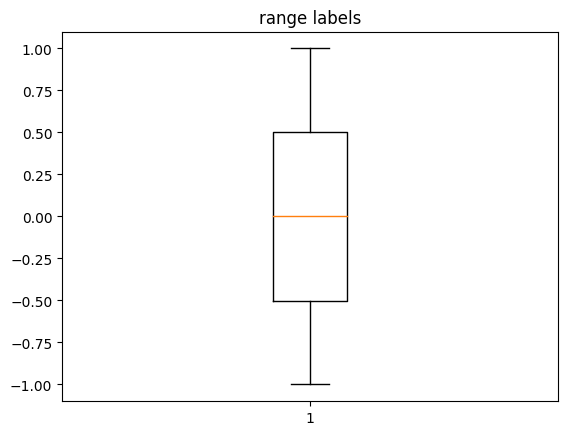

In [21]:
# meake sure we have got uniformly distributed labels
labels = []
for _ in range(inputs_per_date):
  labels = labels + [encode(d) for d in dates]
fig1, ax1 = plt.subplots()
ax1.set_title('range labels')
plt.boxplot(labels)

assert len(conc_attention_mask)==len(labels)
print(f'num labels: {len(labels)}')


In [22]:
# use sklearn for the train test split 
from sklearn.model_selection import train_test_split

test_size = 0.1 #test size
seed = 42 #for reproduzability
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(conc_corpus, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(conc_attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

In [23]:
# create torch data loaders for creating trainable batches of the inputs 
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader

In [24]:
batch_size = 16 #batch size, this is hyperparameter that could be optimized
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)

test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

# Model architecture

I contend that existing techniques place limitations on the potential of pre-trained representations, particularly in the case of fine-tuning approaches. The primary limitation arises from the unidirectional nature of standard language models, which constrains the choice of architectures during pre-training. For instance, in OpenAI GPT, the authors adopt a left-to-right architecture, where each token can only attend to preceding tokens in the self-attention layers of the Transformer (Vaswani et al., 2017). These restrictions prove suboptimal for sentence-level tasks and can be detrimental when applying fine-tuning to token-level tasks, such as question answering, where the incorporation of context from both directions is critical.

Now, let's delve into the actual architecture of the model. BERT consists of an embedding layer followed by 12 stacked transformers.

For every input sequence, BERT produces an output sequence of vectors of the same size. These vectors represent the final hidden states corresponding to each input token, with each vector comprising 768 floats.

The BERT paper specifies that only the final hidden state of the first token in the output sequence should be utilized for classification tasks. In other words, only the vector representing the "[CLS]" token mentioned earlier should be employed.

For the regression task, I will follow the same approach, but instead of adding a dense pooling layer for classification, I will introduce a dense linear layer with dropout. This layer will serve as our final regression layer.

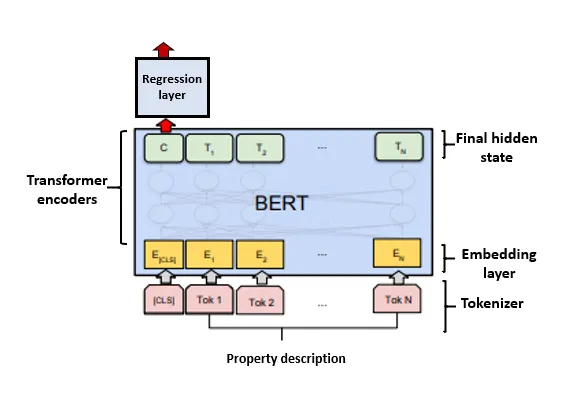

In [ ]:
# get the Bert model from the hugging face library and add a fully connected layer for regression to the CLS output together with a dropout layer  
import torch.nn as nn
from transformers import AutoModel

class BertRegressor(nn.Module):
    
    def __init__(self, drop_rate=0.2, freeze_bert=False):
        
        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1 #the first token of vector dim 768 is used for the regression task 
        
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')
                                                 
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
        

    def forward(self, input_ids, attention_masks):
        
        outputs = self.bert(input_ids, attention_masks)
        outputs = torch.swapaxes(outputs[0], 0, 1) 
        class_label_output = outputs[0]
        outputs = self.regressor(class_label_output)
        return outputs
        

model = BertRegressor(drop_rate=0.2)

In [26]:
#bring the model to GPU 
import torch
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

Using GPU.


BertRegressor(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
# choose optimizer and learning rate for fine tuning (recommended in Bert paper is 5e-5)
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=2e-5, #5e-5, 3e-5, 2e-5
                  eps=1e-8)

In [28]:
# choose epochs and schedule a linear learning rate decrease for reducing the probability of overfitting 
from transformers import get_linear_schedule_with_warmup
epochs = 5 #recommended in paper is 1-2, but I see still improvment on the test data with more iterations
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [29]:
# define mse loss for the regression task in the loss function 
loss_function = nn.MSELoss()

In [ ]:
# train the model 
from torch.nn.utils.clip_grad import clip_grad_norm 
import torch

def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    training_stats = []
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        total_train_loss = 0
        model.train()
        # iterate batches
        for step, batch in enumerate(train_dataloader): 
            print(step)  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            batch_inputs = batch_inputs.to(torch.int64)
            batch_masks = batch_masks.to(torch.int64)
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.T[0], 
                             batch_labels)
            #accumulate train loss
            total_train_loss += loss.item()
            print(f'train loss: {loss}')
            print("-----")

            #backpropagate train loss 
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value) #mitigate the problem of exploding gradients 
            optimizer.step()
            scheduler.step()


        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)   
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))


        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in test_dataloader:

          batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
          batch_inputs = batch_inputs.to(torch.int64)
          batch_masks = batch_masks.to(torch.int64)
    
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              outputs = model(batch_inputs, batch_masks)
              loss = loss_function(outputs.T[0],  batch_labels)
                             
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()


        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(test_dataloader)
        
        print("  Validation Loss: {0:.2f}\n".format(avg_val_loss))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss
            }
        )

                
    return model, training_stats
    
model, training_stats = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)

In [31]:
# create panda of training and validation (here equal to test) loss 
import pandas as pd

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss
epoch,,
1,0.033406,0.014511
2,0.013154,0.013552
3,0.008726,0.011240
4,0.006249,0.011230
5,0.004898,0.010817


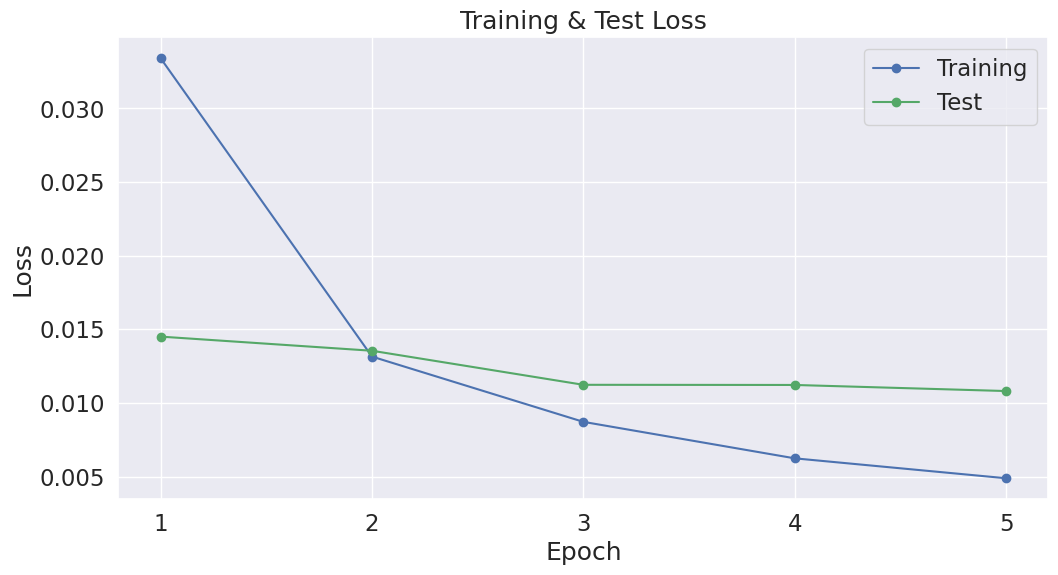

In [32]:
#plot train and test loss over the epochs
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1,epochs+1))

plt.show()

In [33]:
# predictions for the trained model 
def predict(model, dataloader, device):
    model.eval()
    output = []
    labels = []
    for batch in dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                  tuple(b.to(device) for b in batch)
        batch_inputs = batch_inputs.to(torch.int64)
        batch_masks = batch_masks.to(torch.int64)
        labels += batch_labels.view(1,-1).tolist()[0]
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output, labels

In [34]:
# get the predictions on the test data 
output, lables = predict(model, test_dataloader, device) 

In [35]:
# transform the numerical output back into a datetime for more intuitive possibilites of onterpretation
from datetime import datetime

#calculate difference in days 
first_date = decode(np.min(lables))
last_date = decode(np.max(lables))

print(f'the first date is {first_date} and the last one {last_date}')

# convert string to date object
d1 = datetime.strptime(first_date, "%Y-%m-%d")
d2 = datetime.strptime(last_date, "%Y-%m-%d")

# difference between dates in timedelta
delta = d2 - d1
print(f'Difference is {delta.days} days, what is equivalent to {int(delta.days/365)} years')


# decode difference in outouts into difference in days
#[-1,1]-->[0,61489] day
#([-1,1]+1)/2-->[0,1]
#[0,1]*61489-->[0,61489]
day_decode = lambda s: ((s+1)/2)*delta.days

the first date is 1923-06-01 and the last one 2021-06-30
Difference is 35824 days, what is equivalent to 98 years


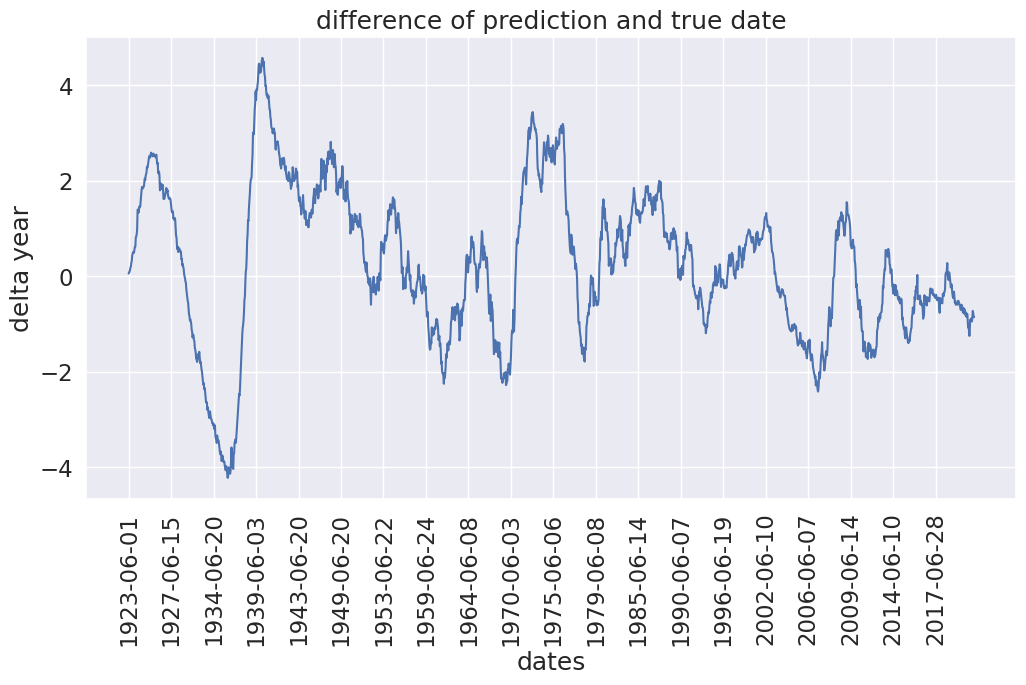

In [36]:
# demonstrate the difference between prediction and true label visually 
difference = day_decode(np.array(output))-day_decode(np.array(lables))
date_labels = [decode(l) for l in np.array(lables)]

sort_ind = sorted(range(len(np.array(lables))), key=lambda k: np.array(lables)[k])
sort_ind = np.array(sort_ind).astype(int)

# filter some noise
from scipy.signal import lfilter
t_year = 365 #days of year
n = 50 # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
yy = lfilter(b, a, difference[sort_ind]) #this is for removing some noise
x = np.arange(len(date_labels)) 
y = np.array(date_labels)[sort_ind]

fig, ax = plt.subplots()
plt.plot(x, yy/t_year)
plt.xticks(x, y, rotation=90)  
ax.locator_params(nbins=20, axis='x')
plt.title('difference of prediction and true date')
plt.xlabel('dates') 
plt.ylabel('delta year')
plt.show()

The overall discrepancy between the predicted dates and the true dates falls within a range of 5 years. It is plausible that during time periods when the language shifts from an older prediction to a more advanced one, a significant global event, such as a war, has occurred. This interruption in continuous development is followed by a transformative change in the world. 


In [37]:
# helper function to find closest existing date in labels to given date
def closest_date(date):
  # convert string to date object
  datetime_dates = []
  datetime_dates = [datetime.strptime(d, "%Y-%m-%d") for d in date_labels]
  datetime_start = datetime.strptime(date, "%Y-%m-%d")


  # difference between dates in timedelta
  delta = [abs((dd-datetime_start).days) for dd in datetime_dates]
  #find closes date
  closest_date = date_labels[np.argmin(delta)]
  return closest_date

In [120]:
# helper function to find the index of the label for a given date
def date2ind(date):
  #find closest date in date_labels
  edate = encode(date)
  temp_array = abs(np.array(lables)-edate) 
  min_ind = np.argmin(temp_array[sort_ind])
  return min_ind

In [121]:
# find the min and max for a given area
#find the closest date
start_date = closest_date('1934-01-01') # type in the start date here
end_date = closest_date('1941-05-31') # type in the end date here 

start_ind = date2ind(start_date)
end_ind = date2ind(end_date)

max_date = (y[start_ind+np.argmax(yy[start_ind:end_ind])])
min_date = (y[start_ind+np.argmin(yy[start_ind:end_ind])])

print('extreme points in the chosen area: \n')
print(f'min date: {min_date}')
print(f'max date: {max_date}')

extreme points in the chosen area: 

min date: 1936-06-06
max date: 1939-06-25


In [113]:
# create word cloud for specific dates to be able to compare differences between dates
def token2cloud(date, n_region):
  ##date: that is plotted into a word cloud
  ##n_region: n closest dates

  #find closest dates in test data
  edate = encode(date)
  temp_array = abs(np.array(lables)[sort_ind]-edate)  
  sorted_ind = np.array(sorted(range(len(temp_array)), key=lambda k: temp_array[k]))
  ind = np.array(range(0,n_region+1)).astype(int) #first neighbour indices
  min_ind = sorted_ind[ind.astype(int)]
  temp_labels_uns = np.array(lables)[sort_ind]
  temp_labels = temp_labels_uns[min_ind]
  dec_labels = [decode(tl) for tl in temp_labels]
  print('\n')
  print('dates: \n')
  print(dec_labels)
  tokens_list = [tokenizer.convert_ids_to_tokens(test_inputs[ind]) for ind in min_ind]
  tokens = [item for sublist in tokens_list for item in sublist]
  #remove punctiution
  tokens = [char for char in tokens if char not in string.punctuation]
  # remove stopwords
  stop = stopwords.words('english')
  tokens = [token for token in tokens if token not in stop]
  # remove words less than three letters
  tokens = [word for word in tokens if len(word) >= 3]
  #remove PAD CLS SEP
  tokens = [word for word in tokens if word not in ['[PAD]', '[CLS]','[SEP]']]
  #remove article and title from tokens
  tokens = [word for word in tokens if word not in ['article', 'title']]
  #plot the word cloud
  plt.figure(figsize=(20,20))
  wc = WordCloud(max_font_size=50, max_words=100, background_color='white')
  wordcloud_jan = wc.generate_from_text(' '.join(tokens))
  plt.imshow(wordcloud_jan, interpolation='bilinear')
  plt.axis('off')
  plt.show()

I would like to examine the period around mid-1936 when the language and words used appeared to be more similar to those used approximately five years prior. Additionally, I want to explore the contrast with a period around three years later (also around mid-1936), when the language suddenly seems to resemble the language used five years later.



dates: 

['1936-06-06', '1936-06-07', '1936-06-04', '1936-06-12', '1935-06-30', '1935-06-29', '1935-06-29', '1936-06-13', '1936-06-14', '1935-06-27', '1936-06-15']


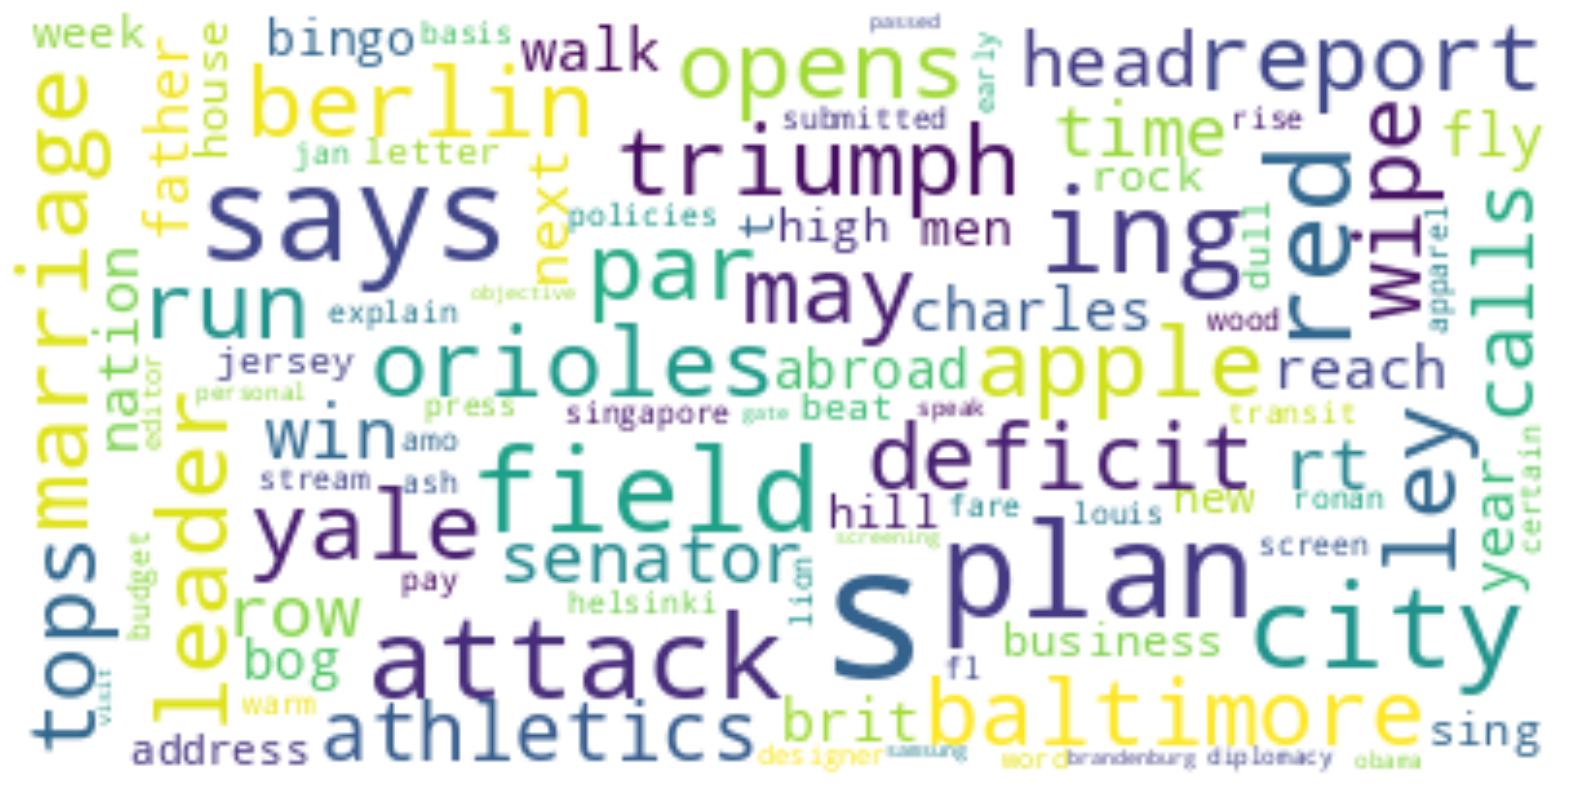

In [127]:
# show the word cloud for the chosen minimum (max negativ difference) with zero other close dates
token2cloud(min_date, 10)

Words that frequently appear and could be correlated to historical events are Berlin, triumph, victory, attack, leader, and deficit. Overall, there seems to be a significant presence of war-related language, which aligns with an older pattern and could explain why the language seems outdated for this time.




dates: 

['1939-06-25', '1939-06-24', '1939-06-26', '1939-06-28', '1939-06-28', '1939-06-29', '1939-06-29', '1939-06-30', '1939-06-18', '1939-06-17', '1939-06-17']


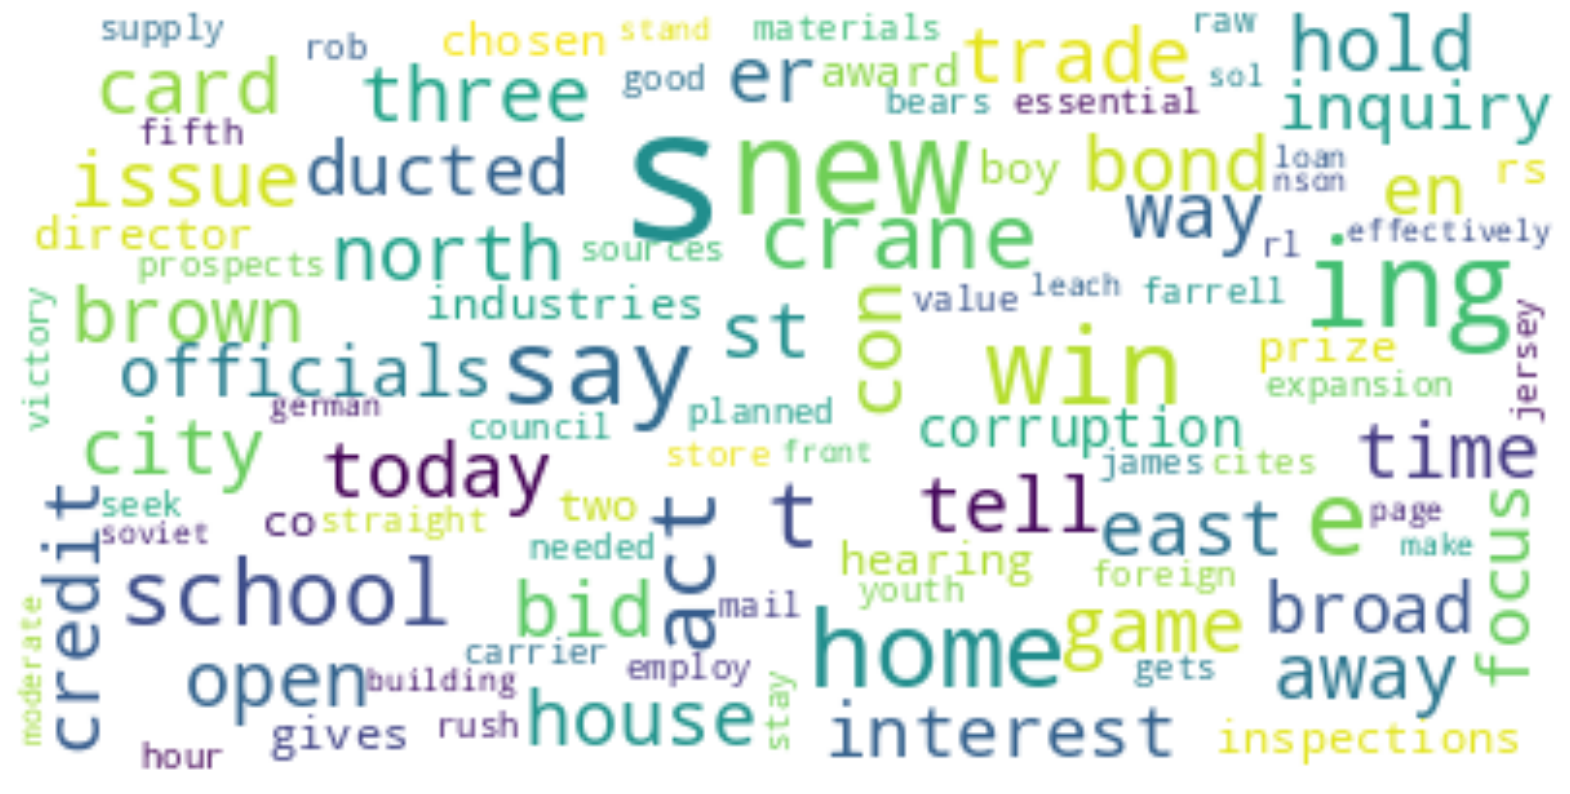

In [128]:
# show the word cloud for the chosen maximum with zero other close dates
token2cloud(max_date, 10)


Words that are frequently used include new, win, interest, credit, house, trade, and corruption. There doesn't seem to be any indication of the forthcoming Second World War, and the language appears to align more with an economic boom or a generally positive economy.

#Conclusion
I have demonstrated that the BERT transformer model can be fine-tuned in a relatively straightforward manner for downstream regression tasks. The predicted labels fall within a range of less than 10 years from the true dates, which, considering a total time span of 100 years, can be considered satisfactory.

This fine-tuning with the date can be used as a task pre-training for which an integration of time would make sense. 

Moreover, the model can be utilized to identify significant historical moments that have influenced the language used. If there is a similarity in the words used during a specific period in the past or future, deviating from a gradual progression over time, it could be indicative of one or multiple events that have impacted this linguistic development. Further analysis could attempt to establish correlations between this linguistic pattern and historical events.